In [7]:
import subprocess
import sys

#!/home/selfetni/anaconda3/bin/python3.9.19
#print("PYTHON VERSION: ",sys.version)
# Install pyDOE using pip
subprocess.call(['pip', 'install', 'pyDOE'])

#!pip install pyDOE

#import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPPclea_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
import math
from numba import jit
# generates same random numbers each time
np.random.seed(1234)
#tf.random.set_seed(1234)
import random
import datetime
import shutil
import json
import glob
import re 

#print("TensorFlow version: {}".format(tf.__version__))
import random
import scipy.io as sio
from importlib import reload
import PINN  # python files (classes)
import pre_post
from pre_post import *
from PINN import *

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [8]:
#@jit(nopython=True)
def generate_circles(mean_r, num_circles, std, Nx, Ny, Nz):
    # Initialize the arrays for the radii and centers of the circles
    R0 = np.zeros(num_circles)
    X_center = np.zeros(num_circles)
    Y_center = np.zeros(num_circles)
    Z_center = np.zeros(num_circles)

    # Generate the first circle randomly
    R0[0] = np.random.normal(loc=mean_r, scale=std)
    X_center[0] = np.random.randint(R0[0], Nx-R0[0])
    Y_center[0] = np.random.randint(R0[0], Ny-R0[0])
    Z_center[0] = np.random.randint(R0[0], Nz-R0[0])

    # Loop through the remaining circles and generate them one at a time
    for i in range(1, num_circles):
        # Flag to indicate whether the new circle overlaps with any existing circles
        overlaps = True
        while overlaps:
            # Generate the radius and center of the new circle randomly
            R0[i] = np.random.normal(loc=mean_r, scale=std)
            X_center[i] = np.random.randint(R0[i], Nx-R0[i])
            Y_center[i] = np.random.randint(R0[i], Ny-R0[i])
            Z_center[i] = np.random.randint(R0[i], Nz-R0[i])

            # Check the new circle against the existing circles
            overlaps = False
            for j in range(i):
                if np.sqrt((X_center[i]-X_center[j])**2 + (Y_center[i]-Y_center[j])**2 ) < (R0[i]+R0[j]): #+ (Z_center[i]-Z_center[j])**2
                    overlaps = True
                    break
    
    return R0, X_center, Y_center, Z_center

##################################################
##################################################
##################################################
if __name__ == '__main__':     ###################
##################################################
##################################################
##################################################    
    #inputs = read_inputs_from_file("Input.txt")

    # Grid parameters
    Nx=65
    Ny=65
    Nt=100 # 500 if los_f

    # Define the domain bounds
    lb = np.array([0, 0,0])
    ub = np.array([1, 1,1]) #np.array([Nx, Ny,Nt])
    dx = (ub[0] - lb[0]) / (Nx - 1)
    dy = (ub[1] - lb[1]) / (Ny - 1)
    dt = (ub[1] - lb[1]) / (Nt - 1)

    # physical parameters
    sigma=1
    mu=1e-3
    delta_g= -250 #-250
    eta=7*dx
    num_phases=1
   
    num_phases=1
    loc_index_0 = 0
    loc_index_1 = 1
    loc_index_2 = 2
    loc_index_3 = 3
    all_phases_indexes= [loc_index_0, loc_index_1, loc_index_2, loc_index_3]
    
    N_batches=4 # base of the pyramid
    min_batch_numbers =4 # upper surface of the pyramid
    # Training batch 
    Nbr_f_pts_max_per_batch= 50 #1000
    Nbr_f_pts_min_per_batch= 40 #100
    N_ini_max_per_batch=65  #50   
    N_ini_min_per_batch=55 #4      
    fraction_ones_per_int_pts=0.
    fraction_zeros_per_int_pts=0.
    coef_increase_points_f=2 # or decrease
    coef_increase_points_ic=2 # or decrease
    

    
    num_train_intervals=Nt
    # Define  Collocations, IC and BC points and Domain bounds
    N_ini =N_ini_max_per_batch*N_batches *num_train_intervals # Total number of data points for 'phi': IC
    N_f = Nbr_f_pts_max_per_batch * N_batches *num_train_intervals    # 100000 Total number of collocation points : domain
    N_b=N_batches*Nt   # Total number of data points for boundary BC
        
    # Total number of data points for 'phi': boundary BC
    x = np.unique(np.linspace(lb[0], ub[0], Nx))
    y = np.unique(np.linspace(lb[1], ub[1], Ny))
    t = np.unique(np.linspace(lb[2], ub[2], Nt))
    f_values = [0, 0.33, 0.67, 1]

    # Generate all combinations of x, y, t, and f
    X, Y, T, F = np.meshgrid(np.linspace(lb[0], ub[0], Nx),
                            np.linspace(lb[1], ub[1], Ny),
                            np.linspace(lb[2], ub[2], Nt),
                            f_values,
                            indexing='ij')

    # Reshape the arrays to create the test matrix
    X_phi_test=np.column_stack((X.flatten(), Y.flatten(), T.flatten()))
    np.savez('X_phi_test.npz', X_phi_test=X_phi_test)
    
    #X_phi_test = np.load('X_phi_test.npz')['arr_0']
    data = np.load('X_phi_test.npz')
    X_phi_test= data['X_phi_test']

    tb = np.linspace(start=lb[2], stop=ub[2], num=N_b, endpoint=True)
    tb = np.expand_dims(tb, axis=1)
    
    # set the saving paths and erase older results
    global pathOutput
    pathOutput = os.path.join(os.getcwd(),'save_figs')
    if not os.path.isdir(pathOutput):
        os.mkdir(pathOutput)
    global pathInput
    pathInput = os.path.join(os.getcwd(),'Initialization')
    if not os.path.isdir(pathInput):
        os.mkdir(pathInput)
    # to store the weights for each time interval 
    path_weights= os.path.join(os.getcwd(),'weights')
    if not os.path.isdir(path_weights):
        os.mkdir(path_weights)

    # load PrePost class
    Pre_Post=PrePost(X=X,T=None, lb=lb, ub=ub, Nx=Nx,Ny=Ny,dx=dx,dy=dy,x=x,y=y, eta=eta,\
            phi_true=None)

    # set the save paths and erase older results
    Pre_Post.EraseFile(path=pathOutput)
    Pre_Post.EraseFile(path=path_weights)
    Pre_Post.EraseFile(path=os.path.join(os.getcwd(),'test_IC'))
    #Pre_Post.EraseFile(path=pathInput) # Initialization 

   
    # Initialize phases
    # get radius and coordinates
    R0, X_center, Y_center,Z_center =\
        generate_circles(mean_r=0.4,num_circles=1, std=0, Nx=Nx, Ny=Ny,Nz=100)
    X_center, Y_center=[0.5],[0.5] # single grain
    phi_0, X_ini_all=Pre_Post.init_micro_cir(R0,X_center,Y_center, Z_center,N_ini,Nx,Ny,x,y,lb,ub) 
    phi_0=phi_0.reshape(1, Nx, Ny)
    X_ini_all=X_ini_all.reshape(1, Nx, Ny)
    # Save into a dictionary
    Initilization_Data = {'phi_0': phi_0}
    np.savez('Initilization_Data_dual.npz', **Initilization_Data)
       
    # Dual
    loaded_data = np.load('Initilization_Data_dual.npz')
    all_phases = loaded_data['phi_0']
    all_interfaces = np.zeros_like(all_phases)
    all_flags_matrix=np.zeros_like(all_phases)
    all_phases_indexes=np.zeros_like(all_phases)
    phases_indexes=all_phases_indexes
    """
    tf.print("phases_indexes shape:", phases_indexes.shape)
    tf.print("all_flags_matrix shape:", all_flags_matrix.shape)
    tf.print("all_phases shape:", all_phases.shape)
    tf.print("all_interfaces shape:", all_interfaces.shape)
    """
    # plot the initial micro
    Pre_Post.plot_init(all_phases,all_phases,Nx,Ny,path=pathOutput)
    
    # get the training data
    X_f_train, X_ini_train_all,X_lb_train,X_ub_train,X_rtb_train,X_ltb_train,phi_ini_all =Pre_Post.set_training_data(x,y,N_ini,\
        all_phases, all_interfaces,all_flags_matrix,N_f,tb,lb,ub,path=pathOutput)
    

X_f_train: (20000, 3), X_ini_all: (4225, 3), X_lb_train: (400, 3), X_ub_train: (400, 3), X_ltb_train: (400, 3), X_rtb_train: (400, 3), phi_ini_all: (4225, 1)


In [10]:
Pre_Post.EraseFile(path=os.path.join(os.getcwd(),'save_figs'))
# load PINN class
import PINN
reload(PINN)  # mandatory to reload content at each re-call atfer modification
from PINN import *

######################################################################## 
# Build PINN 
layers = np.array([3,128,128,128,128,128,128,1])  # Network
PINN_ = Sequentialmodel(layers=layers, X_f_train=X_f_train, X_ini_train=X_ini_train_all,\
                        phases_ini_indexes=phases_indexes,all_ini_flags_matrix=all_flags_matrix,\
                        Phi_ini=all_phases,phi_ini_train=phi_ini_all, N_ini=N_ini,X_phi_test=X_phi_test,\
                        X_ini_train_all=X_ini_train_all, phi_ini_train_all=phi_ini_all,\
                            all_interfaces=all_interfaces,\
                        X_lb_train=X_lb_train, X_ub_train=X_ub_train,\
                        X_ltb_train=X_ltb_train, X_rtb_train=X_rtb_train,\
                        X=X,Y=Y,T=T,x=x,y=y,lb=lb, ub=ub, mu=mu, sigma=sigma, delta_g=delta_g,\
                        eta=eta,Nx=Nx,Ny=Ny,Nt=Nt,phi_sol=None,pinns =None,num_phases=num_phases,
                        N_batches=N_batches,\
                        min_batch_numbers = min_batch_numbers,\
                        Nbr_f_pts_max_per_batch=Nbr_f_pts_max_per_batch,\
                        Nbr_f_pts_min_per_batch=Nbr_f_pts_min_per_batch,\
                        N_ini_max_per_batch=N_ini_max_per_batch,\
                        N_ini_min_per_batch=N_ini_min_per_batch)
path_weights_all_pinns= os.path.join(os.getcwd(),'weights_all_workers_pinns')
if not os.path.isdir(path_weights_all_pinns):
    os.mkdir(path_weights_all_pinns)
pinns=PINN_.Initialize_pinns(path_weights_all_pinns)  


 ! Initilization of all workers pinns 



In [ ]:
path_get_weights_all_pinns= os.path.join(os.getcwd(),'get_weights_all_workers_pinns')

num_boxes = 6
time_subdomains = np.linspace(lb[2], ub[2], num_train_intervals + 1)

plot_percentages = np.around(np.linspace(0, num_train_intervals - 1, num_boxes)).astype(int)
plot_times = [0, 0.5, 0.75,0.85,0.99]
time_range = np.linspace(time_subdomains[0], time_subdomains[-1], num_train_intervals)

box_size = num_train_intervals // num_boxes
num_rows = (num_boxes + 1) // 2

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(9, 4 * num_rows), constrained_layout=True)
iterator=0
phi_evolution=[]

for idx in range(num_train_intervals ):
    if idx < num_train_intervals:
        PINN_.t_min, PINN_.t_max = time_subdomains[idx], time_subdomains[idx + 1]
    else:
        continue 

    PINN_.set_weights_all_pinns(N_batches, path_get_weights_all_pinns)
    X, phi, flag_plot = PINN_.plot_evolution(N_batches, "save_figs", plot_times)
    phi[np.where(phi.flatten() < 1e-6)]=0
    phi_evolution.append(phi)
    if flag_plot is not None:
        if flag_plot == True:
            tf.print(PINN_.t_min, PINN_.t_max)
            #tf.print(X.shape, phi.shape)
            ax=axes.flat[iterator]
            iterator+=1
            scatter=ax.scatter(X[:, 0], X[:, 1], cmap=plt.get_cmap('jet'), c=phi,vmin=0.1,vmax=1)
            if idx==0:
                cbar = fig.colorbar(scatter, ax=ax, shrink=0.5)
                cbar.ax.set_ylabel(r'$\phi$')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            #ax.set_xlim([0,0.8])
            percentage=PINN_.t_min/time_subdomains[-1] *100
            ax.set_title(f'φ at Time: {percentage:.0f}%')

ax=axes.flat[-1]
phi_evolution=np.asarray(phi_evolution)
out_radius_vs_t=[]
for t in range(len(phi_evolution)):   
    phi=phi_evolution[t]
    phi=np.asarray(phi)
    #if t>0.5:
    phi[np.where(phi.flatten() < 1e-3)]+=0
    area=len(phi[np.where(phi.flatten() > 0)[0]])
    raduis=np.sqrt(np.asarray(area) /(Nx*Ny)/np.pi)
    out_radius_vs_t.append(raduis)
out_time=np.linspace(lb[2], ub[2],len(time_subdomains))
ax.plot( out_time[::6],out_radius_vs_t[::6], "b",label=r"$PINN$",linestyle='--')
plt.plot( out_time[::5],R[::5], "r",label=r"$Theory$",marker='o')
ax.set_xlim([lb[2],ub[2]])
ax.set_ylabel([lb[2],ub[2]])
ax.set_ylabel('Radius')
ax.set_title('Grain radius vs. Time') 
plt.legend()            
plt.savefig('save_figs/phi_evolv.jpg')


(100, 4355, 1)


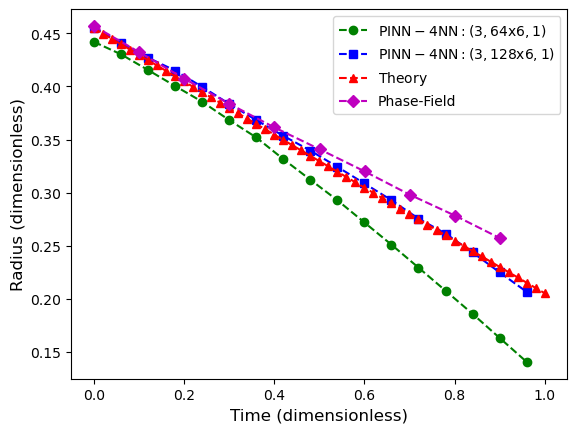

In [14]:
plt.plot()
out_radius_vs_t=[]
phi_evolution=np.asarray(phi_evolution)
tf.print(phi_evolution.shape)
for t in range(len(phi_evolution)):   
    phi=phi_evolution[t]
    phi=np.asarray(phi)
    area=len(phi[np.where(phi.flatten() >= 1e-3)[0]])
    raduis=np.sqrt(np.asarray(area) /(Nx*Ny)/np.pi)
    out_radius_vs_t.append(raduis)

plt.plot(PINN64_out_time[::], PINN64_out_radius_vs_t[::], "g", label=r"$PINN -4 NN :(3,64 x 6,1)$", linestyle='--', marker='o')
plt.plot(out_time[::6], out_radius_vs_t[::6], "b", label=r"$PINN -4 NN :(3,128 x 6,1)$", linestyle='--', marker='s')
plt.plot(out_time[::2], R[::2], "r", label=r"$Theory$", linestyle='--', marker='^')
plt.plot(PF_out_time, PF_out_radius_vs_t, "m", label=r"Phase-Field", linestyle='--', marker='D')

# Customize the plot
plt.xlabel("Time (dimensionless)", fontsize=12)
plt.ylabel("Radius (dimensionless)", fontsize=12)
plt.legend()
plt.show()
#plt.close()

In [13]:
import pickle

# Load the data from the file
with open('PINN_64.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract loaded data
PINN64_out_time = loaded_data['out_time']
PINN64_out_radius_vs_t = loaded_data['out_radius_vs_t']


# Load the data from the file
with open('PF.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Extract loaded data
PF_out_time = loaded_data['out_time']
PF_out_radius_vs_t = loaded_data['out_radius_vs_t']+eta/4 # correction due to raduis set in PF

#### FD resolution

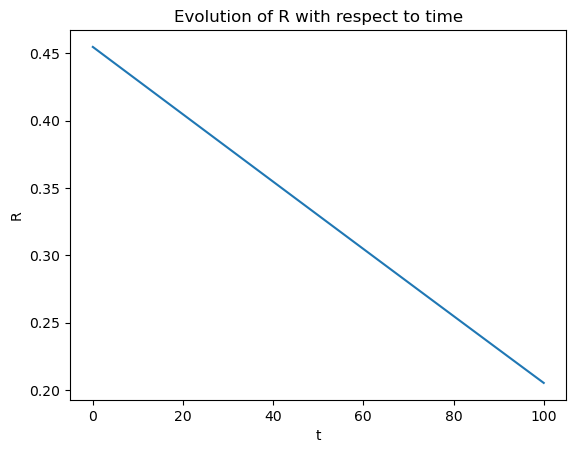

In [15]:

# Initialize array for R values
R = np.zeros(Nt+1)

# Set initial condition
R[0] = R0+eta/2

# Finite difference scheme
for n in range(Nt):
    R[n+1] = R[n] + dt * mu* (sigma / R[n] +delta_g)

# Plotting
#t = np.linspace(0, T, Nt+1)

plt.figure()
plt.plot( R)
plt.xlabel('t')
plt.ylabel('R')
plt.title('Evolution of R with respect to time')
plt.show()


In [5]:
FD_data=R
import pickle

with open('plot_data_FD.pickle', 'wb') as f:
    pickle.dump(FD_data, f)
